
# **Prevendo valores do Preço por Barril do Petróleo bruto Brent (FOB)**

O objetivo deste estudo é conduzir quatro tipos de testes de previsão de séries temporais!

## **Sobre o dataset**

O dataset é composto pelo histórico do valor Preço por barril do petróleo bruto Brent (FOB).

Produzido no Mar do Norte (Europa), Brent é uma classe de petróleo bruto que serve como benchmark para o preço internacional de diferentes tipos de petróleo. Neste caso, é valorado no chamado preço FOB (free on board), que não inclui despesa de frete e seguro no preço.

Link para acessar os dados de Preço: http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

### Construindo o Dataset

#### Importando e checando os dados

In [4]:
# Tentando ler o arquivo CSV com a codificação 'latin1'
dados = pd.read_csv('base preco pretoleo.csv', sep=';')

In [5]:
# Verificando os dados
dados.head()

,Data,Preço do Petróleo
0,21/01/2025,"83,18"
1,20/01/2025,"83,39"
2,17/01/2025,"83,27"
3,16/01/2025,"82,44"
4,15/01/2025,"82,69"


#### Mudando o nome das colunas

In [6]:
# Renomeando as colunas para facilitar os códigos:
dados.rename(columns={'Data': 'data', 'Preço do Petróleo': 'preco'}, inplace=True)

In [7]:
dados.head()

,data,preco
0,21/01/2025,"83,18"
1,20/01/2025,"83,39"
2,17/01/2025,"83,27"
3,16/01/2025,"82,44"
4,15/01/2025,"82,69"


#### Transformando a coluna data em Datetime

In [8]:
dados['data'] = pd.to_datetime(dados['data'], format='%d/%m/%Y')

In [9]:
# Verificando os dados
dados.head()

,data,preco
0,2025-01-21,"83,18"
1,2025-01-20,"83,39"
2,2025-01-17,"83,27"
3,2025-01-16,"82,44"
4,2025-01-15,"82,69"


#### Transformando a coluna preco em int

In [10]:
# Substituindo a vírgula por ponto
dados['preco'] = dados['preco'].str.replace(',', '.')

In [11]:
# verificando a substituição
dados.head()

,data,preco
0,2025-01-21,83.18
1,2025-01-20,83.39
2,2025-01-17,83.27
3,2025-01-16,82.44
4,2025-01-15,82.69


In [12]:
# transformando preço em numerico
dados['preco'] = pd.to_numeric(dados['preco'])

In [13]:
# verificando se as colunas estão corretas
print(dados.dtypes)

data     datetime64[ns]
preco           float64
dtype: object


#### Colocando a coluna data como index

In [14]:
dados.set_index('data', inplace=True)

In [15]:
# Verificando os dados
dados.head()

,preco
data,
2025-01-21,83.18
2025-01-20,83.39
2025-01-17,83.27
2025-01-16,82.44
2025-01-15,82.69


In [16]:
type(dados) #check para ver se realmente a coluna index

pandas.core.frame.DataFrame

#### Visualizando os valores de fechamento das ações

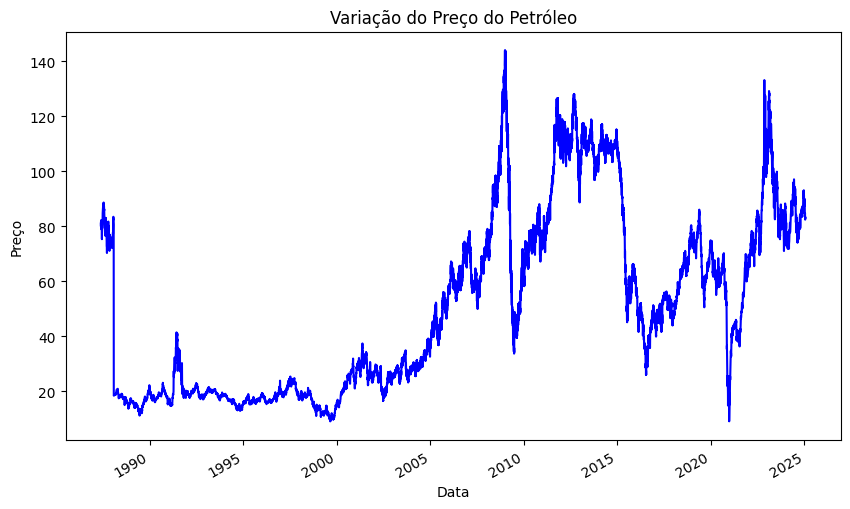

In [17]:
dados['preco'].plot(figsize=(10, 6), linestyle='-', color='b')

# Adicionando rótulos e título ao gráfico
plt.title('Variação do Preço do Petróleo')
plt.xlabel('Data')
plt.ylabel('Preço')

# Exibindo o gráfico
plt.show()

## Decomposição para Análise da série temporal

Utilizaremos o Statsmodel para decompor a série em:

* Tendência, que é a direção da série temporal.
* Sazonalidade, que são os padrões repetidos no tempo.
* Ruído, que é a diferença entre a série original e o explicado por tendência e sazonalidade.


Importância da Decomposição:
A decomposição auxilia na compreensão dos dados e na escolha do modelo preditivo, permitindo:

* Previsões de longo prazo ao compreender a tendência.
* Previsões de curto prazo ao entender a sazonalidade.
* Melhora nos modelos ao analisar os resíduos não capturados.

Série Aditiva ou Multiplicativa:
A decomposição indica se a série é:

* Aditiva: Magnitude de sazonalidade e tendência constante.
* Multiplicativa: Magnitude varia proporcionalmente ao nível da série.

### Decompondo todo dataset em serie, tendência, sazonalidade e ruído

In [18]:
resultados = seasonal_decompose(dados, model='multiplicative', period=5) # Period = sazonaliade. Como temos dados de segunda a sexta, então temos 5, referentes aos 5 dias

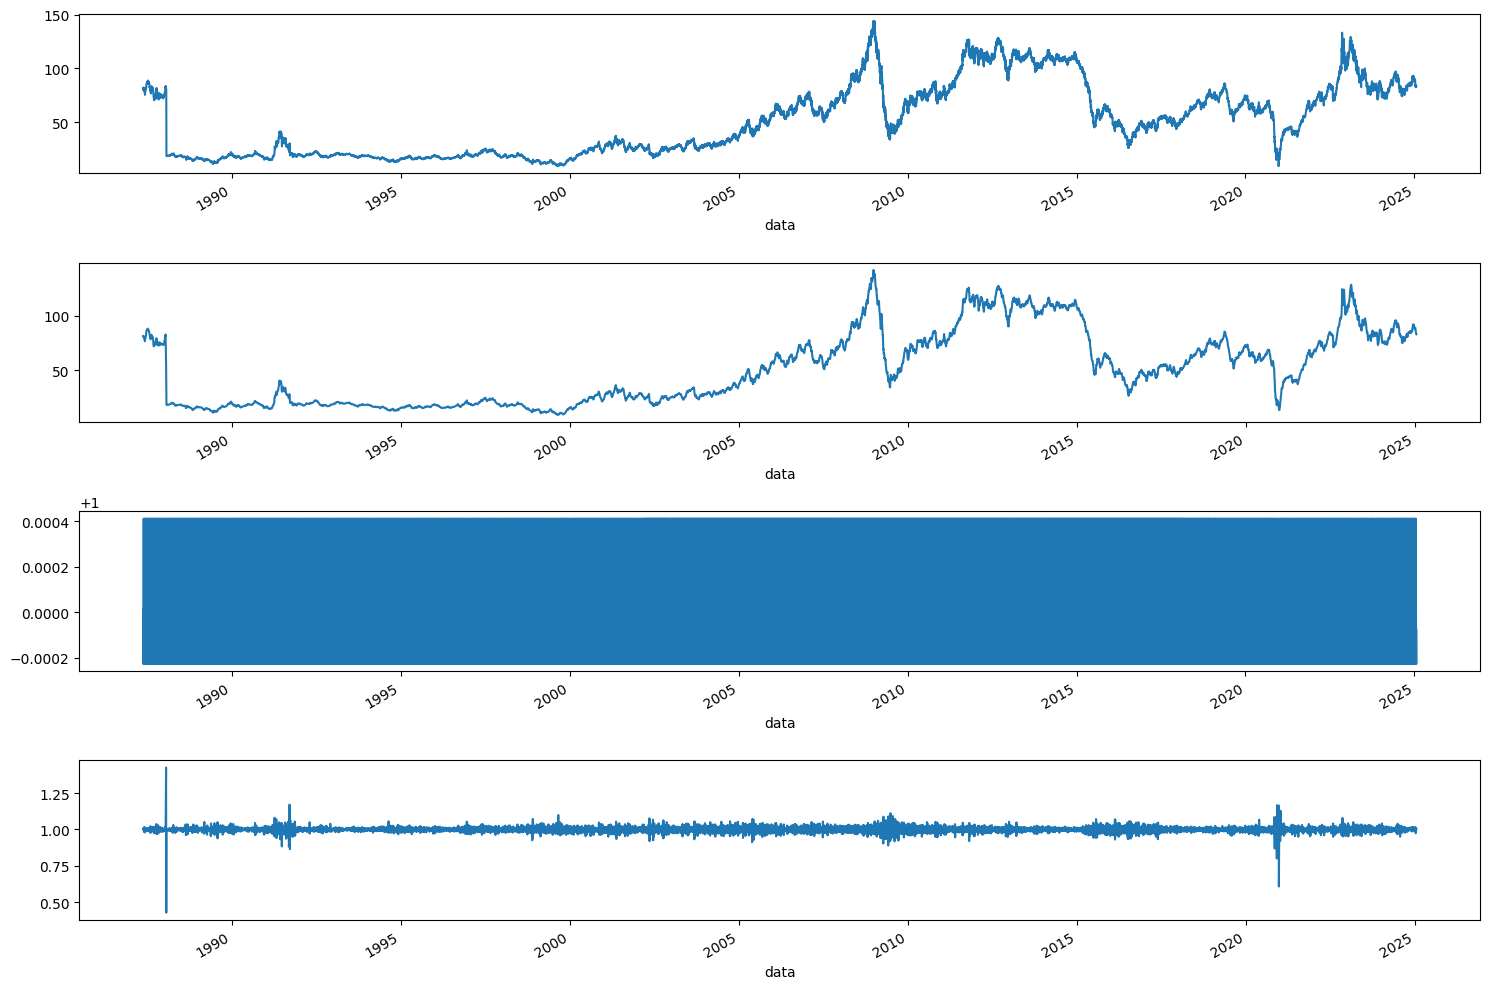

In [19]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,10))

resultados.observed.plot(ax=ax1) # Serie dos dados
resultados.trend.plot(ax=ax2) # tendência dos dados
resultados.seasonal.plot(ax=ax3) # sazonalidade
resultados.resid.plot(ax=ax4) # resíduos

plt.tight_layout()

### Decompondo **5 anos** do dataset em serie, tendência, sazonalidade e ruído

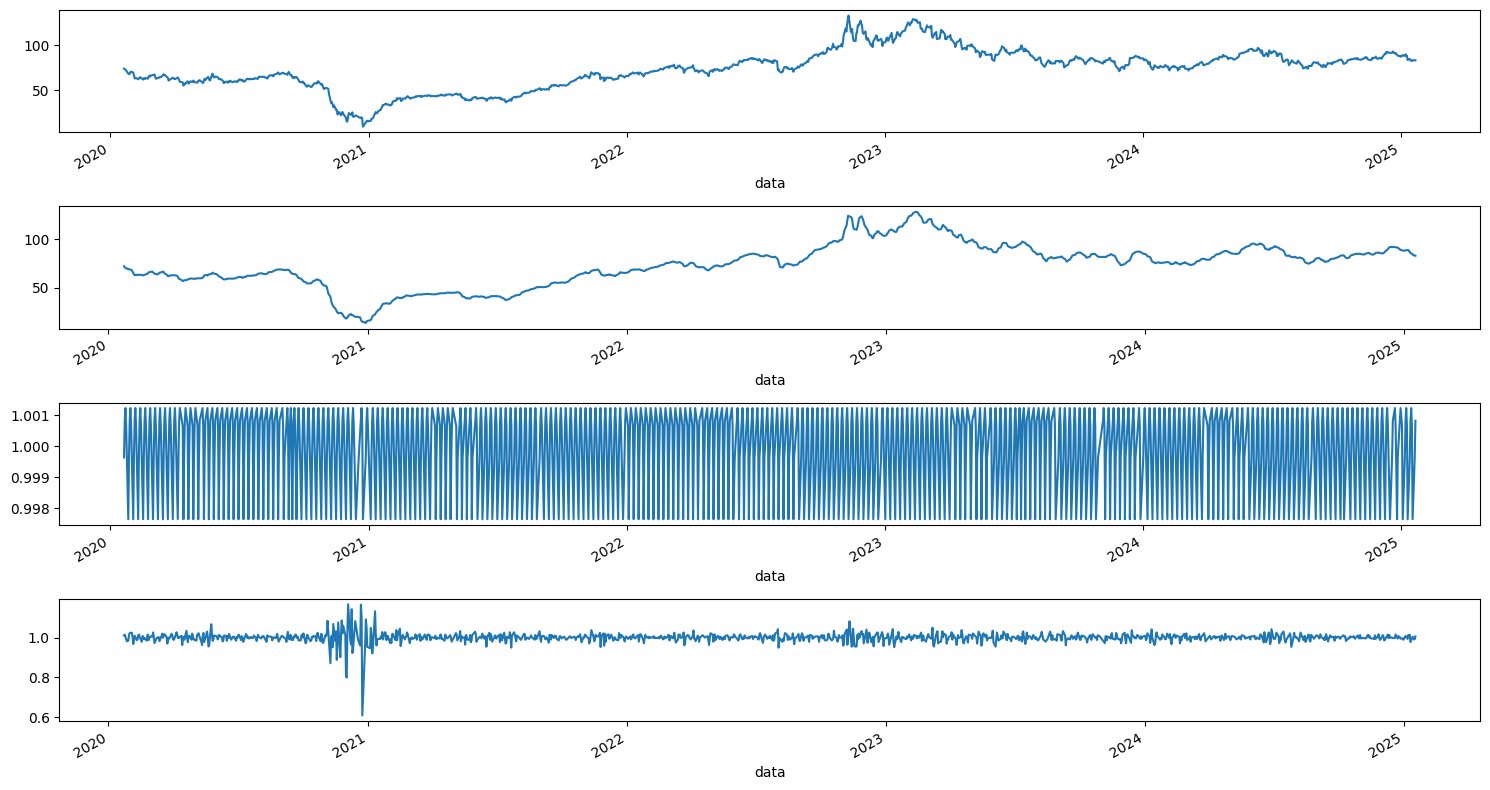

In [20]:
df_5_anos = dados.loc['2020-01-21':]
seasonplot = seasonal_decompose(df_5_anos, model='multiplicative', period=5)  # decompondo a série temporal

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 8))
seasonplot.observed.plot(ax=ax1)  # série real
seasonplot.trend.plot(ax=ax2)  # tendência
seasonplot.seasonal.plot(ax=ax3)  # sazonalidade
seasonplot.resid.plot(ax=ax4)  # resíduos
plt.tight_layout()
plt.show()

## Testando com um modelo Robusto (Prophet)

In [21]:
# Vou puxar os dados de 2023 em diante
dados_resumidos = dados[dados.index >= '2023-01-01']

In [22]:
dados_resumidos.head()

,preco
data,
2025-01-21,83.18
2025-01-20,83.39
2025-01-17,83.27
2025-01-16,82.44
2025-01-15,82.69


In [23]:
dados_resumidos.tail()

,preco
data,
2023-01-06,104.94
2023-01-05,108.36
2023-01-04,108.36
2023-01-03,105.78
2023-01-02,103.30


In [24]:
# Use a função download para obter os dados
df = dados_resumidos.copy()
df['ds'] = df.index
df['y'] = df['preco']
df = df[['ds', 'y']].reset_index(drop=True)
df.head()

,ds,y
0,2025-01-21,83.18
1,2025-01-20,83.39
2,2025-01-17,83.27
3,2025-01-16,82.44
4,2025-01-15,82.69


### Separando os dados em treino e teste

In [25]:
train_data = df.sample(frac=0.7, random_state=0)
test_data = df.drop(train_data.index)
print(f'training data size : {train_data.shape}')
print(f'testing data size : {test_data.shape}')

training data size : (363, 2)
testing data size : (155, 2)


### Criando e plotando o modelo preditivo

In [26]:
modelo = Prophet(daily_seasonality=True)
modelo.fit(train_data)
dataFramefuture = modelo.make_future_dataframe(periods=30, freq='D')
previsao = modelo.predict(dataFramefuture)
previsao.head()

DEBUG:cmdstanpy:input tempfile: /tmp/tmp2p4zkm18/66jbkrc_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2p4zkm18/ttjjunfb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62039', 'data', 'file=/tmp/tmp2p4zkm18/66jbkrc_.json', 'init=/tmp/tmp2p4zkm18/ttjjunfb.json', 'output', 'file=/tmp/tmp2p4zkm18/prophet_model2vjh4otr/prophet_model-20250210232448.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:24:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:24:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-01-02,105.022933,111.730074,120.529245,105.022933,105.022933,11.115000,11.115000,11.115000,9.584883,...,0.170633,0.170633,0.170633,1.359484,1.359484,1.359484,0.0,0.0,0.0,116.137934
1,2023-01-03,104.970441,110.542759,119.182021,104.970441,104.970441,10.074618,10.074618,10.074618,9.584883,...,-0.315389,-0.315389,-0.315389,0.805124,0.805124,0.805124,0.0,0.0,0.0,115.045059
2,2023-01-04,104.917949,110.612729,119.126976,104.917949,104.917949,9.802388,9.802388,9.802388,9.584883,...,-0.045601,-0.045601,-0.045601,0.263106,0.263106,0.263106,0.0,0.0,0.0,114.720337
3,2023-01-05,104.865457,110.273228,119.113973,104.865457,104.865457,9.790949,9.790949,9.790949,9.584883,...,0.462589,0.462589,0.462589,-0.256522,-0.256522,-0.256522,0.0,0.0,0.0,114.656407
4,2023-01-06,104.812965,110.012833,118.653794,104.812965,104.812965,9.411485,9.411485,9.411485,9.584883,...,0.570890,0.570890,0.570890,-0.744288,-0.744288,-0.744288,0.0,0.0,0.0,114.224450


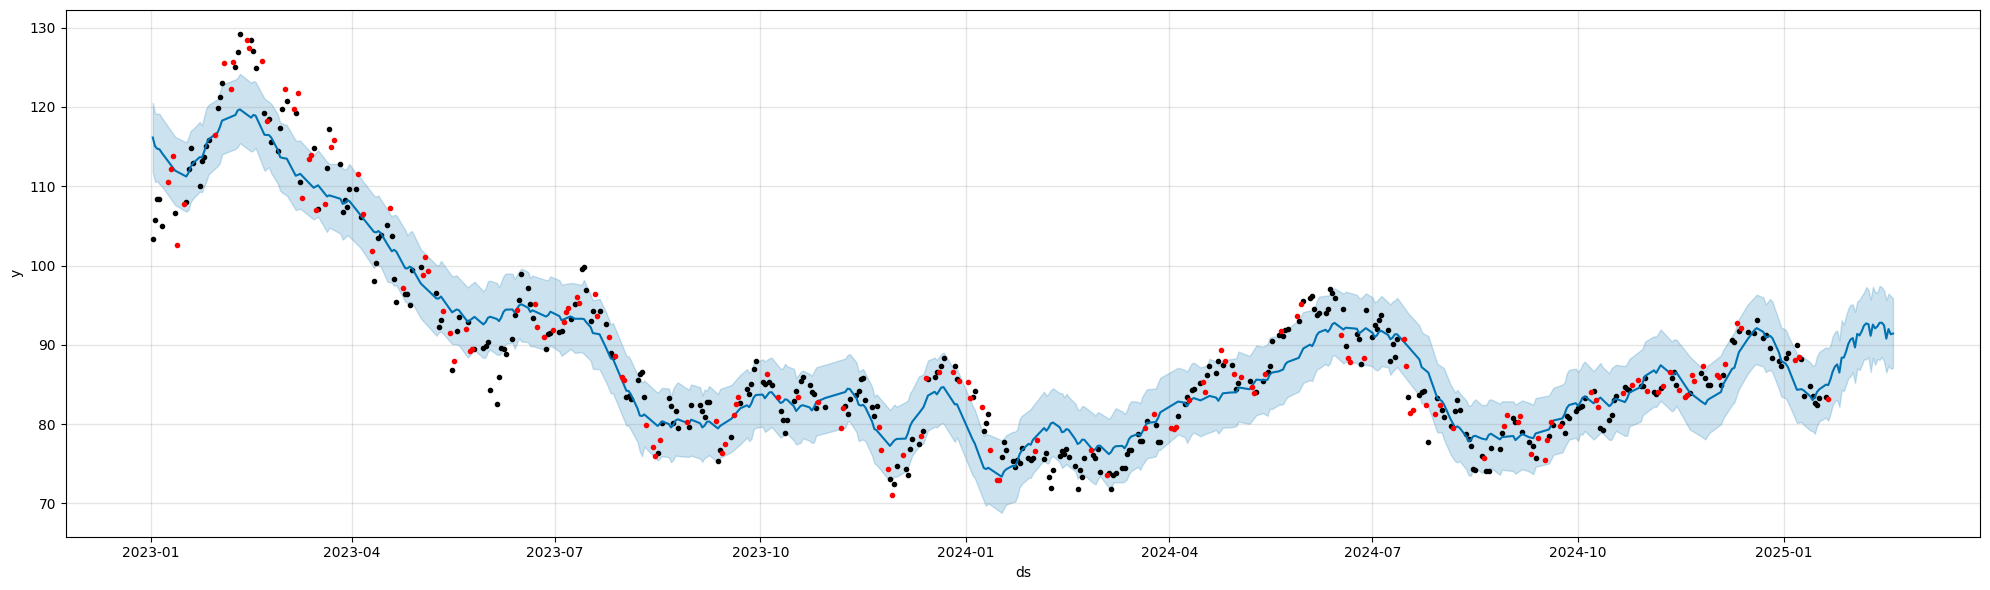

In [27]:
modelo.plot(previsao, figsize=(20,6));
plt.plot(test_data['ds'], test_data['y'], '.r')

### Plotando com ploty

obs:como o github não renderiza javascript, estou colocando abaixo do código, um print do gráfico de ploty

In [28]:
import plotly.graph_objects as go

# Criar uma figura para o gráfico
fig = go.Figure()

# Adicionar a série temporal prevista ao gráfico
fig.add_trace(go.Scatter(x=previsao['ds'], y=previsao['yhat'], mode='lines', name='Previsão'))

# Adicionar os pontos de teste ao gráfico
fig.add_trace(go.Scatter(x=test_data['ds'], y=test_data['y'], mode='markers', marker=dict(color='red'), name='Dados de Teste'))

# Layout do gráfico
fig.update_layout(title='Previsão do Modelo',
                  xaxis_title='Data',
                  yaxis_title='Valor',
                  showlegend=True,
                  xaxis=dict(rangeslider=dict(visible=True), type='date'))

# Exibir o gráfico
fig.show()

### Decompondo os dados:

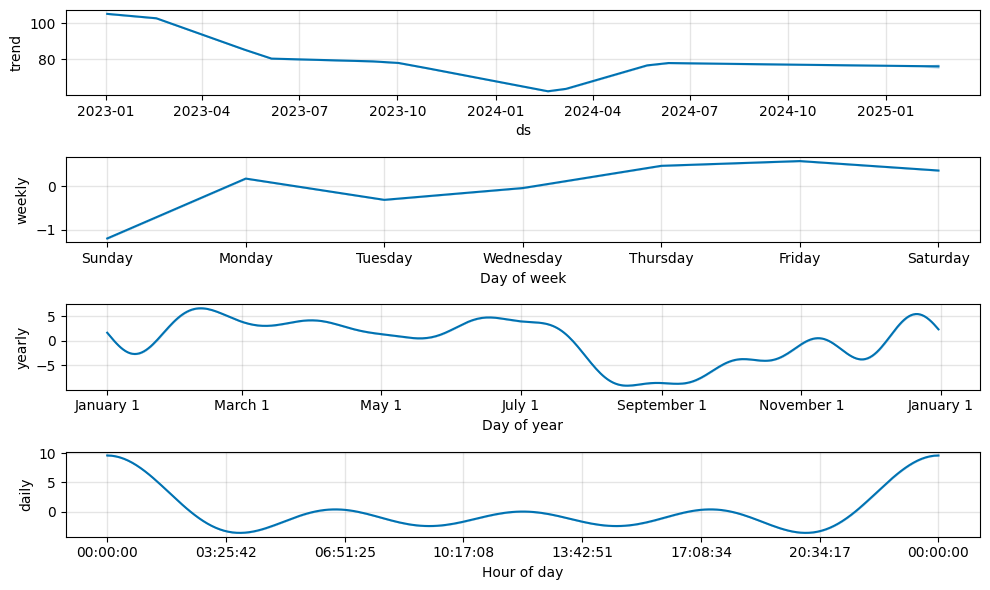

In [29]:
modelo.plot_components(previsao, figsize=(10,6));

In [30]:
# Extrair as colunas relevantes dos DataFrames
previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']

previsao = previsao[previsao_cols]
valores_reais = train_data[valores_reais_cols]

# Mesclar os DataFrames nas colunas 'ds' para comparar previsões e valores reais
resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

# Calcular o erro percentual absoluto para cada ponto de dados
resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

# Calcular o MAPE
mape = np.mean(resultados['erro_percentual_absoluto'])

print(f"MAPE: {mape:.2f}%")

MAPE: 2.99%


In [31]:
import pandas as pd

# Gerar datas para os próximos 90 dias
data_futuro = pd.date_range(start=df['ds'].max(), periods=30, freq='D')[1:]
data_futuro = pd.DataFrame(data_futuro, columns=['ds'])

# Fazer previsões para os próximos 90 dias
previsao_futuro = modelo.predict(data_futuro)

# Selecionar as colunas relevantes
tabela_previsao = previsao_futuro[['ds', 'yhat']].rename(columns={'yhat': 'previsao'})

# Exibir a tabela
print(tabela_previsao)

           ds   previsao
0  2025-01-22  85.639355
1  2025-01-23  86.628934
2  2025-01-24  87.237370
3  2025-01-25  87.532819
4  2025-01-26  86.494913
5  2025-01-27  88.375576
6  2025-01-28  88.391480
7  2025-01-29  89.146958
8  2025-01-30  90.118930
9  2025-01-31  90.664070
10 2025-02-01  90.853709
11 2025-02-02  89.671230
12 2025-02-03  91.372771
13 2025-02-04  91.179576
14 2025-02-05  91.700790
15 2025-02-06  92.418276
16 2025-02-07  92.693676
17 2025-02-08  92.603221
18 2025-02-09  91.135024
19 2025-02-10  92.549720
20 2025-02-11  92.072735
21 2025-02-12  92.317036
22 2025-02-13  92.767903
23 2025-02-14  92.789962
24 2025-02-15  92.461976
25 2025-02-16  90.774135
26 2025-02-17  91.988703
27 2025-02-18  91.332302
28 2025-02-19  91.418687
